In [1]:
# Install tensorly package
! pip install tensorly
# Install PIL package for image utility
! pip install pillow

zsh:1: command not found: pip


In [2]:
import os
import time
import numpy as np
import tensorly as tl
from PIL import Image
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from tensorly.decomposition import tucker
from scipy import sum
from scipy.linalg import norm, svd

import warnings
warnings.filterwarnings('ignore')

## Utility functions

In [3]:
def to_image(tensor):
    """A convenience function to convert from a float dtype back to uint8"""
    im = tl.to_numpy(tensor)
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(np.uint8)


def img_to_tensor_from_file(fname):
    if os.path.isfile(fname) and fname[-3:] in ["jpg", "png"]:
        img = Image.open(fname)
        img_tensor = tl.tensor(zoom(img, (0.5, 0.5, 1)), dtype='float64')
        return img_tensor, img_tensor.shape

## Higher-Order Singular Value Decomposition algorithm from scratch

We implemented the essential steps in the HOSVD algorithm, including the Kronecker product of matrices and the Tucker decomposition algorithm.

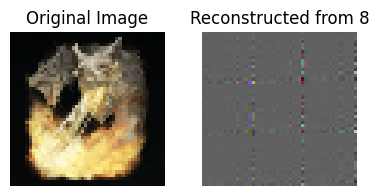

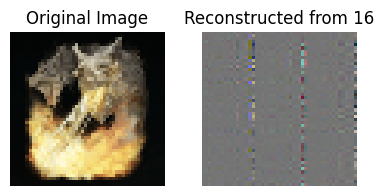

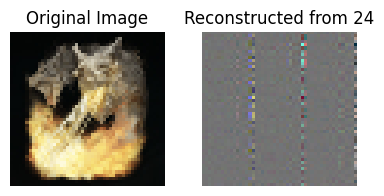

In [4]:
def kron(A, B):
    C = tl.tensor(np.empty((A.shape[0]*B.shape[0], A.shape[1]*B.shape[1])))

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            C[i, j] = A[i // B.shape[0], j // B.shape[1]] * \
                B[i % B.shape[0], j % B.shape[1]]
    return C


def kron_products(X, R, decomp=True):
    svds = []
    #
    for k in range(1, 3):
        U, s, VT = svd(tl.unfold(X, k))
        if decomp:
            svds.append(U.T[:R, :])
        else:
            svds.append(U)
    return kron(svds[0], svds[1]).T


def tucker_svd(X, R):
    # Only using the left singular matrix
    U, _, _ = svd(tl.unfold(X, 0))
    Ak = U[:R, :]
    y = kron_products(X, R)

    temp = tl.matmul(Ak, tl.unfold(X, 0))
    g = tl.matmul(temp, y)
    G = tl.fold(g, 0, (R, R, 3))

    A2 = svd(tl.unfold(X, 0))[0][:R, :]
    A1 = svd(tl.unfold(X, 1))[0][:R, :]
    A0 = svd(tl.unfold(X, 2))[0][:R, :]
    return G, [A0, A1, A2]


def inv_tucker_svd(G, factors, shape):
    products = kron(factors[1], factors[2])
    # print(products.shape)
    # print(tl.unfold(G, 2).shape)
    # print(factors[0].shape)
    temp = tl.matmul(factors[0], tl.unfold(G, 2))
    # print(temp.shape)
    X = tl.matmul(temp, products).reshape(shape)
    return X, to_image(X)


# for rank in range(20):
for rank in range(3,25):
    test_T, test_shape = img_to_tensor_from_file("data/100xpla.jpg")
    g, factors = tucker_svd(test_T, rank)
    r, r_as_img = inv_tucker_svd(g, factors, test_shape)

    if rank % 8 == 0:
        fig = plt.figure(figsize=(4,2))
        ax = fig.add_subplot(1, 2, 1)
        ax.set_axis_off()
        ax.imshow(to_image(test_T))
        ax.set_title('Original Image')

        ax = fig.add_subplot(1, 2, 2)
        ax.set_axis_off()
        ax.imshow(r_as_img)
        ax.set_title(f'Reconstructed from {rank}')

        plt.tight_layout()
        plt.show()

## Tucker decomposition experiment using Tensorly

The Tensorly package tucker decomposition deploys the HOOI (Higher Order Orthogonal Iteration) algorithm.

The time complexity of this [algorithm](https://github.com/tensorly/tensorly/blob/main/tensorly/decomposition/_tucker.py) 
is $O(N\cdot d\cdot r^2)$, where:

- $N$ is the number of elements in the tensor, 
- $d$ is the number of modes,
- $r$ is the maximum rank of the core tensor. 

This complexity comes from the fact that each iteration involves computing a multi-mode product, which has a time complexity of $O(N\cdot d\cdot r)$, and then performing a singular value decomposition on one of the modes of the tensor, which has a time complexity of $O(r^2)$. 

Since the algorithm repeats this process a number of times equal to the maximum number of iterations, the overall time complexity is $O(N\cdot d\cdot r^2)$.



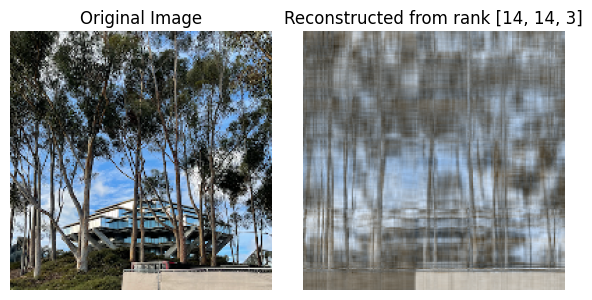

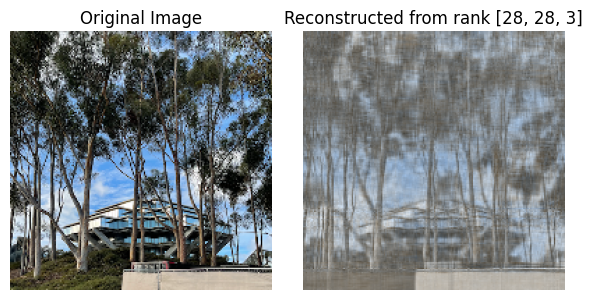

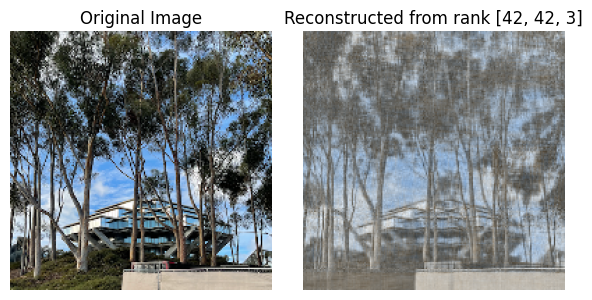

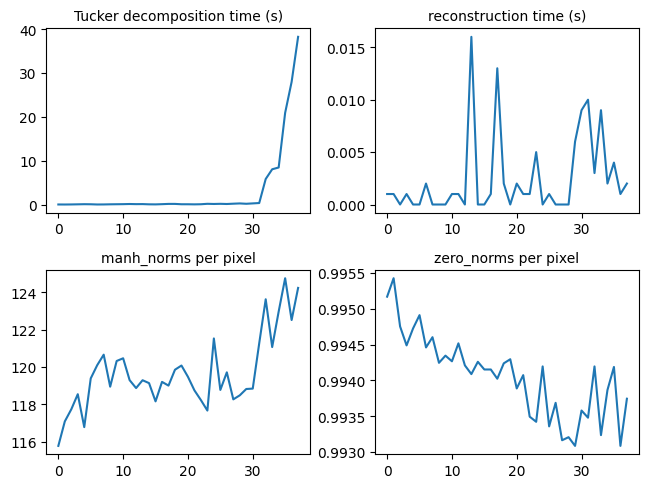

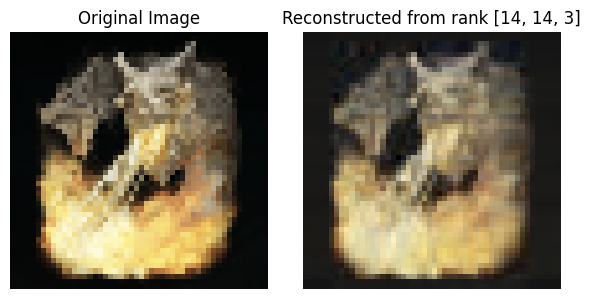

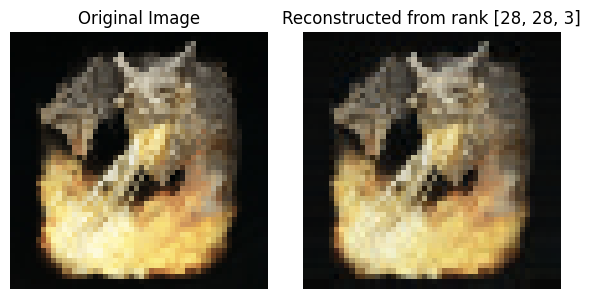

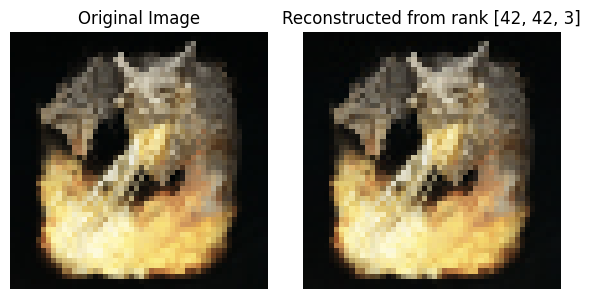

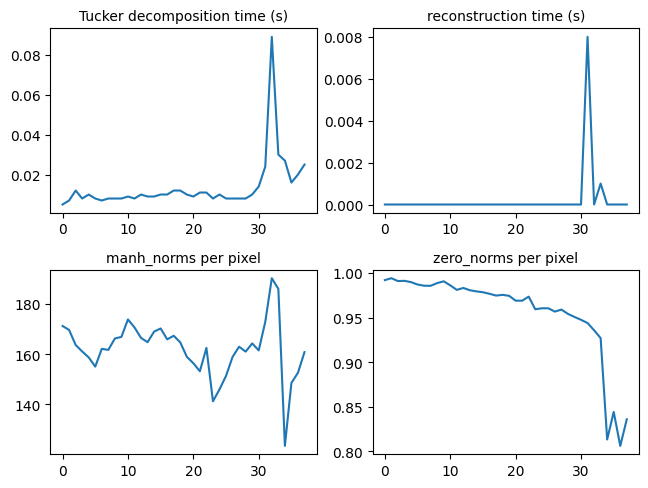

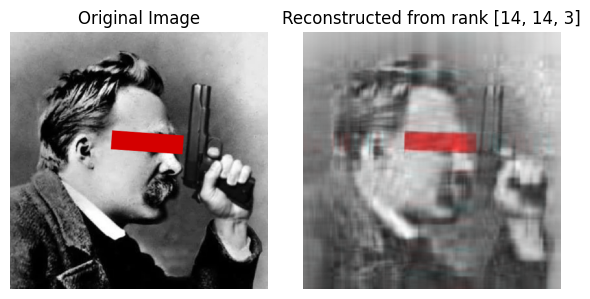

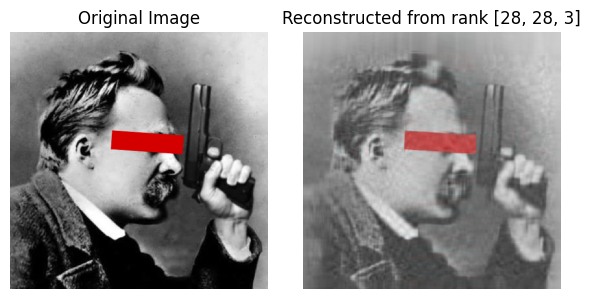

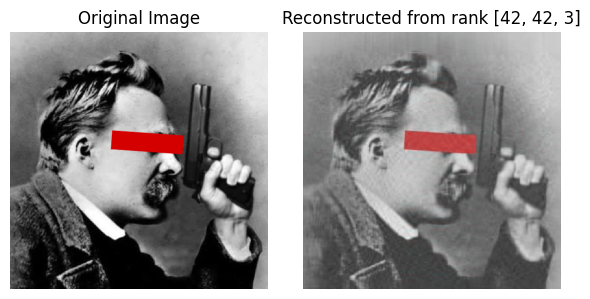

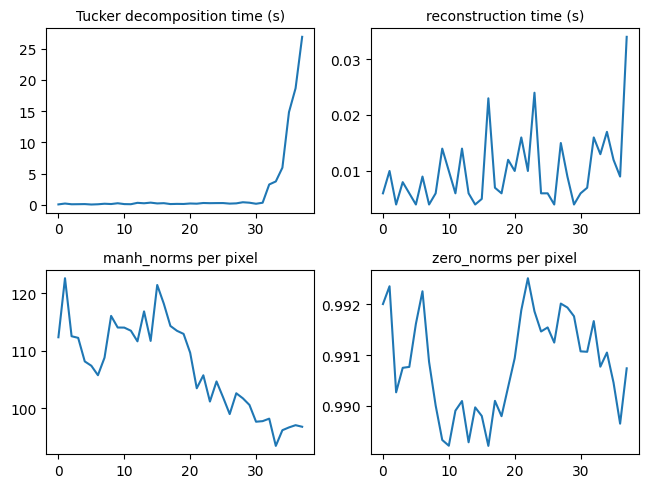

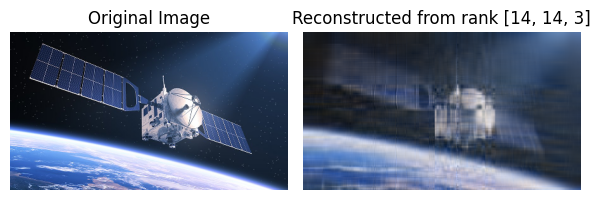

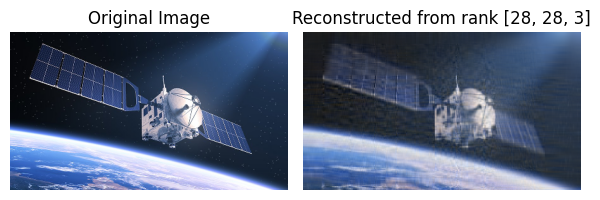

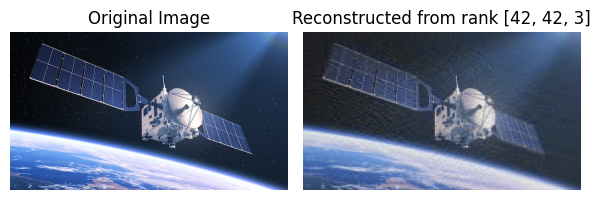

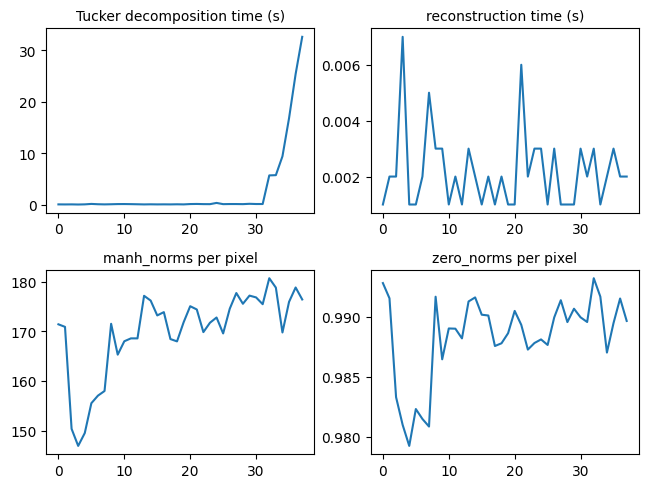

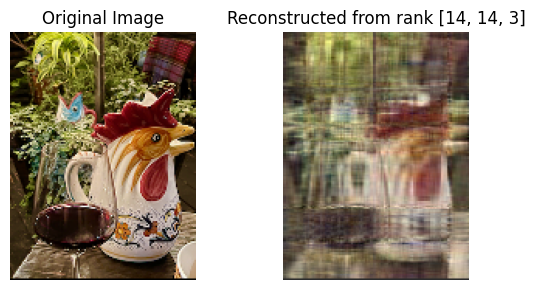

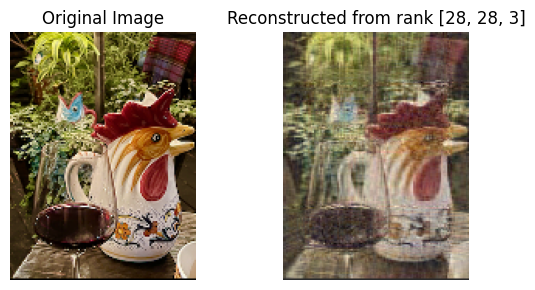

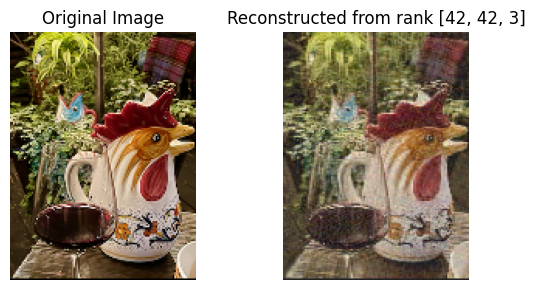

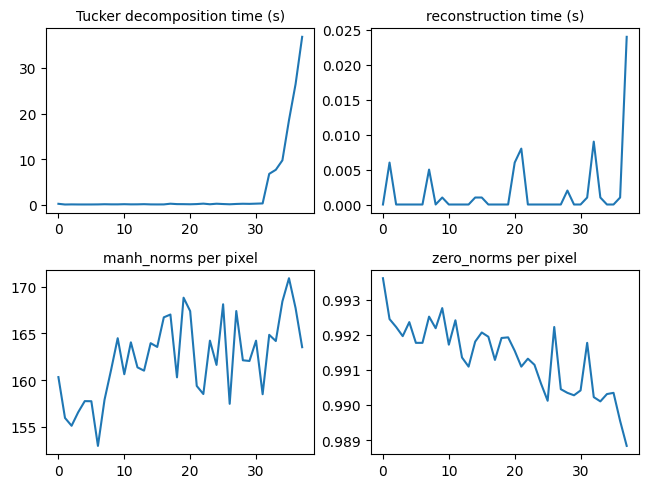

In [5]:
# Data structure to hold the benchmark data points
tucker_time = []
recon_time = []
manh_norms = []
zero_norms = []


def tucker_experiment(img, rank):
    # Time the decomposition and reconstructions
    start = time.time()
    core, tucker_factors = tucker(img, rank=rank, init='random', tol=10e-5, random_state=12345)
    end = time.time()
    tucker_time.append(round(end-start, 3))

    start = time.time()
    tucker_reconstruction = tl.tucker_to_tensor((core, tucker_factors))
    end = time.time()
    recon_time.append(round(end-start, 3))

    # Plot
    if rank[0] % 14 == 0:
        fig = plt.figure(figsize=(6,3))
        ax = fig.add_subplot(1, 2, 1)
        ax.set_axis_off()
        ax.imshow(to_image(img))
        ax.set_title('Original Image')

        ax = fig.add_subplot(1, 2, 2)
        ax.set_axis_off()
        ax.imshow(to_image(tucker_reconstruction))
        ax.set_title(f'Reconstructed from rank {rank}')

        plt.tight_layout()
        plt.show()
    
    diff = to_image(img) - to_image(tucker_reconstruction)
    m_norm = sum(abs(diff))  # Manhattan norm
    manh_norms.append(m_norm/to_image(img).size)
    z_norm = norm(diff.ravel(), 0)  # Zero norm, ravel() flattens the array like reshape(-1)
    zero_norms.append(z_norm*1.0/to_image(img).size)


PATH = "data/"
for filename in os.listdir(PATH):
    f = os.path.join(PATH, filename)
    if os.path.isfile(f) and f[-3:] in ["jpg", "png"]:
        img, img_shape = img_to_tensor_from_file(f)

        # run experiments
        for i in range(5,43):
            tr = [i,i,3]
            tucker_experiment(img, tr)

        def plot_lines(ax, arr, title):
            ax.plot(arr)
            ax.set_title(title, fontsize=10)

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
        plot_lines(ax1, tucker_time, "Tucker decomposition time (s)")
        plot_lines(ax2, recon_time, "reconstruction time (s)")
        plot_lines(ax3, manh_norms, "manh_norms per pixel")
        plot_lines(ax4, zero_norms, "zero_norms per pixel")

        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.show()

        # Reset graphs
        tucker_time = []
        recon_time = []
        manh_norms = []
        zero_norms = []